In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse
import heartpy as hp
import os
import pickle

In [2]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    
    return results


def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    # fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    fxx, pxx = signal.welch(x=rri,fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    # peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    # results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    results['VLF_p'] = vlf/total_power
    results['LF_p'] = lf/total_power
    results['HF_p'] = hf/total_power
    results['LF_n'] = lf_nu
    results['HF_n'] = hf_nu
    results['LFHF'] = lf/hf
    return results, fxx, pxx


def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

def preprocessing(ppg_data, view = False, participant = ''):
    # moving average function
    m_avg = lambda t, x, w : (np.asarray([t[i] for i in range(w, len(x) - w)]),
                          np.convolve(x, np.ones((2*w + 1, )) / (2*w + 1),
                                      mode = 'valid'))

    fs = len(ppg_data)/(60)  # sample rate

    # moving average
    w_size = int(fs*.5)  # width of moving window
    times = list(range(0,len(ppg_data)))
    mt, ms = m_avg(times, ppg_data, w_size)

    sign = (ppg_data[w_size:-w_size]-ms)

    analytical_signal = np.abs(signal.hilbert(sign))

    fs = len(sign) / (max(mt) - min(mt))
    w_size = int(fs)
    mt_new, mov_avg = m_avg(mt, analytical_signal, w_size)

    signal_pure = sign[w_size : -w_size] / mov_avg
    
    if view:
        plt.ioff()
        
        fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
        ax1.plot(times, ppg_data, "b-", label="Original")
        ax1.legend(loc='best')
        ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

        ax2.plot(mt, sign, 'r-', label="Pure signal")
        ax2.plot(mt_new, mov_avg, 'b-', label='Modulation', alpha=.5)
        ax2.legend(loc='best')
        ax2.set_title("Raw -> filtered", fontsize=14)#, fontweight="bold")

        ax3.plot(mt_new, signal_pure, "g-", label="Demodulated")
        ax3.set_xlim(0, mt[-1])
        ax3.set_title("Raw -> filtered -> demodulated", fontsize=14)#, fontweight="bold")

        ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
        ax3.legend(loc='best')

        fig.tight_layout()
        plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')
        
    return signal_pure

def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/63), prominence=0.01)
    result = []
    peaks = []
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2
            
def get_NNIntervals(ppg):
    result, peaks, _ = get_peaks(ppg)
    NN_intervals = []
    for i in range(len(result)-1):
        nn = result[i+1] - result[i]
        NN_intervals.append(nn)
    
    return NN_intervals


def visualization(title, ppg):
    plt.figure(figsize=(20,8))
    plt.plot(ppg)
    plt.title(title, color="black")
    plt.tick_params(axis="both",colors="black")
    
def visualization_nn(title, diff_sig_2, peaks, positions):
    plt.figure(figsize=(20,8))
    plt.plot(diff_sig_2)
    plt.scatter(peaks,positions, color="red")
    plt.title(title)
    plt.gca().set_xlim(0,8064)
    plt.show
    plt.savefig('/tmp/elias/emotion_recognition/testplot.png')

def take_features_Valence(segmented_data):
    
    diff_sig_2=np.diff(segmented_data)

    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
    rr_2 = np.diff(peaks_2)
    corr_rr_2 = rr_2*10
    results_T = timedomain(corr_rr_2)
    x_2 = np.cumsum(rr_2)/ 100.0
    f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")

    # sample rate for interpolation
    fs = 4.0
    steps = 1 / fs

    # now we can sample from interpolation function
    xx_2 = np.arange(1, np.max(x_2), steps)
    rr_interpolated = f_2(xx_2)
    
    results_F, fxx_2, pxx_2 = frequency_domain(rr_interpolated)

    # new_data = {
    #     'meanNN': results_T['Mean RR (ms)'],
    #     'medianNN': np.median(rr_2),
    #     'NN50': np.sum(np.abs(np.diff(rr_2)) >= 50)*1 ,
    #     'VLFa': results_F['Power VLF (ms2)'],
    #     'LFa': results_F['Power LF (ms2)'], 
    #     'HFa': results_F['Power HF (ms2)'],
    #     'TOTALa': results_F['Power Total (ms2)'],
    #     'VLFp': results_F['VLF_p'],
    #     'LFp' : results_F['LF_p'],
    #     'HFp': results_F['HF_p'] 
    # }
    new_data = [
        results_T['Mean RR (ms)'],
        np.median(rr_2),
        np.sum(np.abs(np.diff(rr_2)) >= 50)*1 ,
        results_F['Power VLF (ms2)'],
        results_F['Power LF (ms2)'], 
        results_F['Power HF (ms2)'],
        results_F['Power Total (ms2)'],
        results_F['VLF_p'],
        results_F['LF_p'],
        results_F['HF_p'] 
    ]
    
    return new_data
    
# def take_features_Arousal(segmented_data):
#     diff_sig_2=np.diff(segmented_data)

#     peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
#     rr_2 = np.diff(peaks_2)
#     corr_rr_2 = rr_2*10
#     results_T = timedomain(corr_rr_2)
#     x_2 = np.cumsum(rr_2)/ 100.0
#     f_2 = interp1d(x_2, rr_2, kind='cubic',fill_value="extrapolate")

#     # sample rate for interpolation
#     fs = 4.0
#     steps = 1 / fs

#     # now we can sample from interpolation function
#     xx_2 = np.arange(1, np.max(x_2), steps)
#     rr_interpolated = f_2(xx_2)
    
#     print("Frequency domain metrics:")
#     results_F, fxx_2, pxx_2 = frequency_domain(rr_interpolated)

#     for k, v in results_F.items():
#         print("- %s: %.2f" % (k, v))

#     new_data = {
#         'meanNN': results_T['Mean RR (ms)'],
#         'SDNN' : ,
#         'RMSSD' : results_T['RMSSD (ms)'],
#         'LFa': results_F['Power LF (ms2)'], 
#         'HFa': results_F['Power HF (ms2)'],
#         'VLFp': results_F['VLF_p'],
#         'LFp' : results_F['LFp'],
#         'HFp': results_F['HF_p'],
#         'LFn' : ,
#         'LFHF' : 
#     }
    
#     return new_data

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
# dir_list_.pop(0)
dir_list = dir_list_

In [4]:
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
    
    file_num += 1

In [5]:
df_PPG.head(5)

,participant,video_number,ppg,valence,arousal
0,0,0,"[8121.617533123139, 8078.161162384611, 8065.46...",1,1
1,0,1,"[788.487211825035, 683.9966125211577, 604.8962...",1,1
2,0,2,"[-10340.018466416446, -10405.4471594385, -1049...",1,1
3,0,3,"[5761.629905022521, 5858.796396898557, 5914.94...",0,1
4,0,4,"[235.95451299435808, 46.99254135604133, -118.0...",1,0


In [6]:
df_PPG.tail(5)

,participant,video_number,ppg,valence,arousal
1275,31,35,"[-15.438773556366868, 13.779922454859843, 13.0...",0,1
1276,31,36,"[-72.23391600921241, -88.20263650304878, -70.8...",0,1
1277,31,37,"[31.275658356296844, -12.318011093610039, 21.8...",0,1
1278,31,38,"[2.7456817755301017, 6.464424904232146, -4.848...",0,1
1279,31,39,"[6.198312114656801, 19.29203792075714, -7.2391...",1,0


In [7]:
PPG_data = df_PPG['ppg']
Valence = df_PPG['valence']
Arousal = df_PPG['arousal']

preprocessed = []

## display
# count = 0
# for PPG in PPG_data:
#     vid_num = 19
#     if count % 40 == vid_num:
#         participant = str(int(count / 40))+f'[{vid_num}]'
#         preprocessed_d = preprocessing(PPG,view=True,participant=participant)
#         preprocessed.append(preprocessed_d)
#     else:
#         preprocessed_d = preprocessing(PPG,view=False)
#         preprocessed.append(preprocessed_d)
#     count += 1

for PPG in PPG_data:
    preprocessed_d = preprocessing(PPG,view=False)
    preprocessed.append(preprocessed_d)

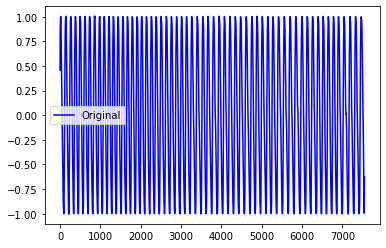

In [8]:
seconds = 60
sample = 128 * seconds
times = list(range(0,len(preprocessed[8])))
raw_data = PPG_data[8]
ppg_data = preprocessed[8]
ppg_data = ppg_data[:sample]
plt.plot(times, ppg_data, "b-", label="Original")
plt.legend(loc='best')
# plt.set_title("participants"+str(participant)+" Raw", fontsize=14)
# fig.tight_layout()
plt.savefig(f'./preprocessed.png', bbox_inches='tight')

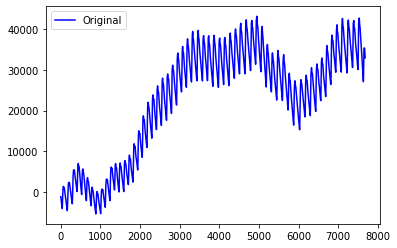

In [9]:
times = list(range(0,len(PPG_data[8])))
plt.plot(times, raw_data, "b-", label="Original")
plt.legend(loc='best')
# plt.set_title("participants"+str(participant)+" Raw", fontsize=14)
# fig.tight_layout()
plt.savefig(f'./raw.png', bbox_inches='tight')

In [10]:
# abort unavailable data
preprocessed = preprocessed[:-40*11]
len(preprocessed)

840

In [11]:
sampling_rate = 128
seconds = 15 ###
seg_window = sampling_rate * seconds
segmented = []
valence_data = []
arousal_data = []

index = 0
for PPG in preprocessed:
    temp = []
    for i in range(seg_window, len(PPG), seg_window):
        valence_data.append(Valence[index])
        arousal_data.append(Arousal[index])
        segmented.append(PPG[i-seg_window:i])
    index = index+1

print(f"segmented length : {len(segmented)}, time window : {len(segmented[0])}")

segmented length : 2520, time window : 1920


In [12]:
seg = np.array(segmented)
pre = np.array(preprocessed)

In [13]:
seg.shape, pre.shape

((2520, 1920), (840, 7550))

In [14]:
index = 0
# FOR Valence
df = pd.DataFrame(columns=[
        'meanNN','medianNN','NN50','VLFa','LFa','HFa','TOTALa','VLFp','LFp','HFp'
        ])
features = []
for window in segmented:
    try:
        df_features = take_features_Valence(window)
    except:
        print(str(index)+" error")
        
    # dfNew = pd.DataFrame(df_features, columns=['meanNN','medianNN','NN50','VLFa','LFa','HFa','TOTALa','VLFp','LFp','HFp'])
    # df = pd.concat([df, dfNew], ignore_index=True)
    # df = df.append(df_features, ignore_index=True)
    
    # df = pd.concat([df, df_features],ignore_index=True)
    # df.to_csv(f'./features_new/{index}vid_Valence{Valence[index]}.csv')
    # index = index + 1
# df_features
    features.append(df_features)

/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 72, using nperseg = 72
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 69, using nperseg = 69
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 68, using nperseg = 68
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 70, using nperseg = 70
  warnings.warn('nperseg = {0:d} is greater than input l

In [15]:
index = 0
window = 20
timestep = 10
x = []
valence = []
arousal = []

# for feature in features:
#     temp = []
#     for i in range(window, len(feature), timestep):
#         valence.append(valence_data[index])
#         arousal.append(arousal_data[index])
#         x.append(feature[i-window:i])
#     index = index+1
for index in range(len(features) - timestep): 
    x.append(features[index: index + timestep])
    # valence.append(valence_data[index])
    # arousal.append(arousal_data[index])
    
valence = valence_data[timestep:]
arousal = arousal_data[timestep:]

In [16]:
a = np.array(features)
x = np.array(x)
y = np.array(valence)
print(a.shape,x.shape,y.shape)

(2520, 10) (2510, 10, 10) (2510,)


In [17]:
train_samples = int(len(x)*0.8)

train_x = x[:train_samples]
train_valence = valence[:train_samples]
train_arousal = arousal[:train_samples]

test_x = x[train_samples:]
test_valence = valence[train_samples:]
test_arousal = arousal[train_samples:]

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
# import np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
x_train_data = np.array(train_x).astype(np.float64)
x_test_data = np.array(test_x).astype(np.float64)
y_train_data = np.array(train_valence).astype(np.float64)
y_test_data = np.array(test_valence).astype(np.float64)

print(x_train_data.shape, y_train_data.shape, x_test_data.shape, y_test_data.shape)
# x_train_data = x_train_data.reshape((x_train_data.shape[0],x_train_data.shape[1], x_train_data.shape[2]))
# x_test_data = x_test_data.reshape((x_test_data.shape[0],x_test_data.shape[1], x_test_data.shape[2]))

# normalize train data
nsamples, nx, ny = x_train_data.shape
train_dataset = x_train_data.reshape((nsamples,nx*ny))
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_data = scaler.fit_transform(train_dataset)
# normalize test data
Test_nsamples, Test_nx, Test_ny = x_test_data.shape
test_dataset = x_test_data.reshape((Test_nsamples,Test_nx*Test_ny))
scaler = MinMaxScaler(feature_range=(0, 1))
x_test_data = scaler.fit_transform(test_dataset)

print(x_train_data.shape, x_test_data.shape)

X_train = x_train_data.reshape((x_train_data.shape[0],nx,ny))
X_test = x_test_data.reshape((x_test_data.shape[0], Test_nx, Test_ny))
Y_train = y_train_data.reshape((y_train_data.shape[0], 1))
Y_test = y_test_data.reshape((y_test_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")
print(f"X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}")

(2008, 10, 10) (2008,) (502, 10, 10) (502,)
(2008, 100) (502, 100)
X_train shape : (2008, 10, 10), Y_train shape : (2008, 1)
X_test shape : (502, 10, 10), Y_test shape : (502, 1)


In [20]:
# Set Hyperparameters of the model
learning_rate = 0.001
epochs = 200
batch_size=64

In [21]:
# one GRU layers with three dense layers-> IT WORKS !
model = Sequential()
model.add(GRU(units=128,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               53760     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 251,393
Trainable params: 251,393
Non-trainable params: 0
__________________________________________________

In [22]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(X_test,Y_test),
                  verbose=1)

Epoch 1/200
32/32 [==============================] - 1s 46ms/step - loss: 0.6882 - accuracy: 0.5354 - val_loss: 0.6927 - val_accuracy: 0.5199
Epoch 2/200
32/32 [==============================] - 1s 34ms/step - loss: 0.6877 - accuracy: 0.5413 - val_loss: 0.6934 - val_accuracy: 0.5259
Epoch 3/200
32/32 [==============================] - 1s 36ms/step - loss: 0.6887 - accuracy: 0.5398 - val_loss: 0.6933 - val_accuracy: 0.5139
Epoch 4/200
32/32 [==============================] - 1s 40ms/step - loss: 0.6882 - accuracy: 0.5488 - val_loss: 0.6970 - val_accuracy: 0.5020
Epoch 5/200
32/32 [==============================] - 1s 45ms/step - loss: 0.6854 - accuracy: 0.5498 - val_loss: 0.6955 - val_accuracy: 0.5219
Epoch 6/200
32/32 [==============================] - 1s 40ms/step - loss: 0.6866 - accuracy: 0.5388 - val_loss: 0.6986 - val_accuracy: 0.4821
Epoch 7/200
32/32 [==============================] - 1s 37ms/step - loss: 0.6829 - accuracy: 0.5518 - val_loss: 0.6848 - val_accuracy: 0.5558
Epoch 

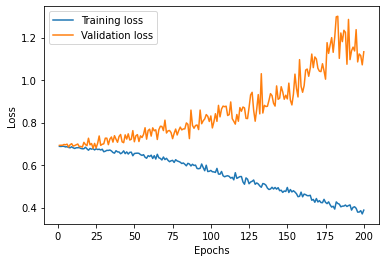

<Figure size 432x288 with 0 Axes>

In [23]:
epoch = np.arange(1,epochs+1)
plt.plot(epoch, history.history['loss'], label='Training loss')
plt.plot(epoch, history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('fig1loss')

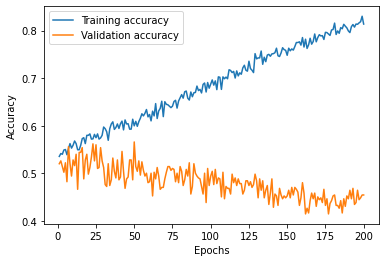

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('fig1acc')